## Load in the data

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
NUM_MICE_FREEZE = 6
NUM_MICE_FEED = 7
from MPNeuro.plotting import prettify_axes
import importlib

In [2]:
col_names = ['a', 'b', 'time', 'freq', 'mouse_id', 'train_test', 'distance', 'immobile_dur', 'c']
freeze_df = pd.read_csv('CalcRL freezing.csv', sep = ';', encoding='utf-16', skiprows=4, header=None)
freeze_df.columns = col_names
freeze_df.drop(freeze_df.columns[-1], axis = 1, inplace=True)
freeze_df.sort(columns = ['freq', 'train_test', 'mouse_id', 'time'], inplace=True)
freeze_df.head()

,a,b,time,freq,mouse_id,train_test,distance,immobile_dur
619,Result 1,Trial 51,0:00:27.500-0:00:55.000,0Hz,959,0hr Test,80.794,13.06650
620,Result 1,Trial 51,0:00:55.000-0:01:22.500,0Hz,959,0hr Test,123.181,0.00000
621,Result 1,Trial 51,0:01:22.500-0:01:50.000,0Hz,959,0hr Test,109.342,0.33333
618,Result 1,Trial 51,Start-0:00:27.500,0Hz,959,0hr Test,168.850,0.00000
627,Result 1,Trial 53,0:00:27.500-0:00:55.000,0Hz,962,0hr Test,162.220,0.00000


In [3]:
one_min_sum = freeze_df['immobile_dur'] + np.roll(freeze_df['immobile_dur'], -1)
freeze_df['immobile_roll_sum'] = one_min_sum

In [4]:
grouped_df_mean= freeze_df.groupby(['time', 'freq', 'train_test']).mean()
grouped_df_mean.drop('mouse_id', axis = 1, inplace=True)
grouped_df_mean.index = grouped_df_mean.index.swaplevel(0, 2)
grouped_df_mean.index = grouped_df_mean.index.swaplevel(0, 1)
grouped_df_mean.sortlevel(level = ['freq', 'train_test', 'time'], inplace=True)
grouped_df_mean.head(3)

distance  immobile_dur  \
freq train_test time                                                
0Hz  0hr Test   0:00:27.500-0:00:55.000   97.499400     11.910982   
                0:00:55.000-0:01:22.500  122.293433      8.505505   
                0:01:22.500-0:01:50.000   61.931200      8.805345   

                                         immobile_roll_sum  
freq train_test time                                        
0Hz  0hr Test   0:00:27.500-0:00:55.000          20.416487  
                0:00:55.000-0:01:22.500          17.310850  
                0:01:22.500-0:01:50.000          10.483198

In [5]:
grouped_df_std = freeze_df.groupby(['time', 'freq', 'train_test']).std()
grouped_df_std.drop('mouse_id', axis = 1, inplace=True)
#grouped_df_std.columns = ['dist_std', 'immobile_std']
grouped_df_std.index = grouped_df_std.index.swaplevel(0, 2)
grouped_df_std.index = grouped_df_std.index.swaplevel(0, 1)
grouped_df_std.sortlevel(inplace=True)
grouped_df_std.head(3)

distance  immobile_dur  \
freq train_test time                                               
0Hz  0hr Test   0:00:27.500-0:00:55.000  56.561819     10.470379   
                0:00:55.000-0:01:22.500  40.855893      7.769607   
                0:01:22.500-0:01:50.000  30.147056      7.481105   

                                         immobile_roll_sum  
freq train_test time                                        
0Hz  0hr Test   0:00:27.500-0:00:55.000          11.690783  
                0:00:55.000-0:01:22.500          12.158329  
                0:01:22.500-0:01:50.000           9.973600

## Plot freezing during training

In [6]:
mov_40Hz = grouped_df_mean.loc['40Hz', 'Train'].immobile_dur
mov_40Hz = np.roll(mov_40Hz, 1) 
mov_20Hz = grouped_df_mean.loc['20Hz', 'Train'].immobile_dur
mov_20Hz = np.roll(mov_20Hz, 1) 
mov_5Hz = grouped_df_mean.loc['5Hz', 'Train'].immobile_dur
mov_5Hz = np.roll(mov_5Hz, 1)

mov_40Hz_std = grouped_df_std.loc['40Hz', 'Train'].immobile_dur
mov_40Hz_std = np.roll(mov_40Hz_std, 1) / np.sqrt(NUM_MICE_FREEZE)
mov_20Hz_std = grouped_df_std.loc['20Hz', 'Train'].immobile_dur
mov_20Hz_std = np.roll(mov_20Hz_std, 1) / np.sqrt(NUM_MICE_FREEZE)
mov_5Hz_std = grouped_df_std.loc['5Hz', 'Train'].immobile_dur
mov_5Hz_std = np.roll(mov_5Hz_std, 1)/ np.sqrt(NUM_MICE_FREEZE)

In [7]:
mov_20Hz.shape

(17,)

### Plotting parameters

In [40]:
fs = 20
color_dict = {5: 'blue', 20:'red', 40:'black', 0:'orange'}
lw = 3

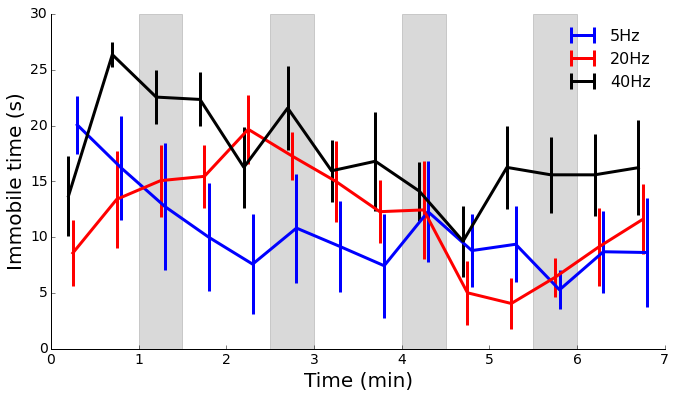

In [36]:
fig, ax = plt.subplots(1, figsize=[11, 6])
last_index =14
time_indices = np.arange(last_index) / 2+0.25
plt.errorbar(time_indices+0.05, mov_5Hz[:last_index], mov_5Hz_std[:last_index], label = '5Hz', linewidth = lw, capsize = 0, color=color_dict[5])
plt.errorbar(time_indices, mov_20Hz[:last_index], mov_20Hz_std[:last_index], label = '20Hz', linewidth = lw, capsize = 0, color=color_dict[20])
plt.errorbar(time_indices-0.05, mov_40Hz[:last_index], mov_40Hz_std[:last_index], label = '40Hz', linewidth = lw, capsize = 0, color=color_dict[40])
laser_times = [[1, 1.5], [2.5, 3], [4, 4.5], [5.5, 6]]
for cur_laser in laser_times:
    plt.axvspan(cur_laser[0], cur_laser[1], facecolor =  'k', alpha = 0.15)
    
plt.legend(frameon = False, fontsize = fs-4)
prettify_axes(plt.gca())
plt.xlabel('Time (min)', fontsize = fs)
plt.ylabel('Immobile time (s)', fontsize = fs);
fig.savefig('Training timecourse.png')

## Plot freezing during test

Calculate means

In [9]:
test_40Hz_mean = grouped_df_mean.loc['40Hz', '24hr Test'].immobile_roll_sum 
test_40Hz_mean = np.roll(test_40Hz_mean, 1)
test_20Hz_mean = grouped_df_mean.loc['20Hz', '24hr Test'].immobile_roll_sum
test_20Hz_mean = np.roll(test_20Hz_mean, 1)
test_5Hz_mean = grouped_df_mean.loc['5Hz', '24hr Test'].immobile_roll_sum
test_5Hz_mean = np.roll(test_5Hz_mean, 1)
test_0Hz_mean = grouped_df_mean.loc['0Hz', '0hr Test'].immobile_roll_sum
test_0Hz_mean = np.roll(test_0Hz_mean, 1)

Calculate std's

In [10]:
test_40Hz_ste = grouped_df_std.loc['40Hz', '24hr Test'].immobile_roll_sum / np.sqrt(NUM_MICE_FREEZE)
test_40Hz_ste = np.roll(test_40Hz_ste, 1)
test_20Hz_ste = grouped_df_std.loc['20Hz', '24hr Test'].immobile_roll_sum / np.sqrt(NUM_MICE_FREEZE)
test_20Hz_ste = np.roll(test_20Hz_ste, 1)
test_5Hz_ste = grouped_df_std.loc['5Hz', '24hr Test'].immobile_roll_sum / np.sqrt(NUM_MICE_FREEZE)
test_5Hz_ste = np.roll(test_5Hz_ste, 1)
test_0Hz_ste = grouped_df_std.loc['0Hz', '0hr Test'].immobile_roll_sum / np.sqrt(NUM_MICE_FREEZE)
test_0Hz_ste = np.roll(test_0Hz_ste, 1)

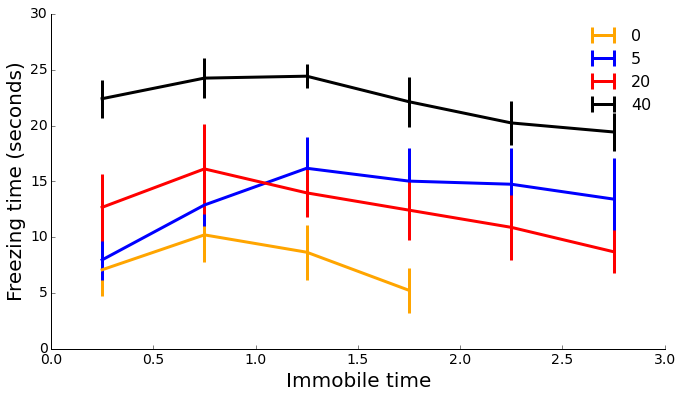

In [42]:
fig, ax = plt.subplots(1, figsize=[11, 6])
last_index =6
time_indices = np.arange(last_index) / 2+0.25
plt.errorbar(time_indices[:4], test_0Hz_mean / 2, test_0Hz_ste / 2, label = '0', linewidth = lw, color=color_dict[0], capsize = 0)
plt.errorbar(time_indices, test_5Hz_mean[:last_index] / 2, test_5Hz_ste[:last_index] / 2, label = '5', linewidth = lw, color=color_dict[5], capsize = 0)
plt.errorbar(time_indices, test_20Hz_mean[:last_index] / 2, test_20Hz_ste[:last_index] / 2, label = '20', linewidth = lw, color=color_dict[20], capsize = 0)
plt.errorbar(time_indices, test_40Hz_mean[:last_index] / 2, test_40Hz_ste[:last_index] / 2, label = '40', linewidth = lw, color=color_dict[40], capsize = 0)
plt.legend(frameon = False, fontsize = fs-4)
plt.xlabel('Immobile time', fontsize = fs)
plt.ylabel('Freezing time (seconds)', fontsize = fs)
prettify_axes(plt.gca())
fig.savefig('Testing timecourse.png')

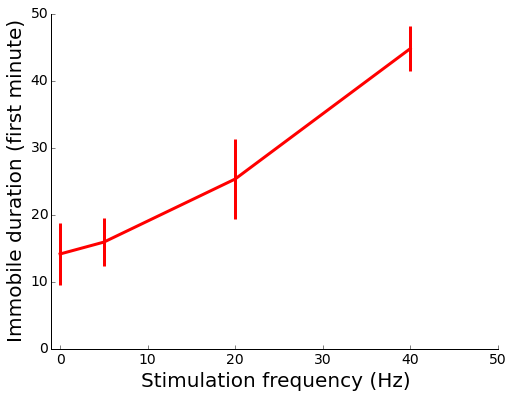

In [52]:
fig, ax = plt.subplots(1, figsize = [8, 6])
freeze_indices = np.array([0,  5, 20, 40])
freq_means = [test_0Hz_mean[0], test_5Hz_mean[0], test_20Hz_mean[0], test_40Hz_mean[0]]
freq_stes = [test_0Hz_ste[0],  test_5Hz_ste[0], test_20Hz_ste[0], test_40Hz_ste[0]]
plt.errorbar(freeze_indices, freq_means, freq_stes, linewidth=lw, capsize = 0, color = 'red')
plt.xlim([-1, 50])
plt.ylim([0, 50])
plt.ylabel('Immobile duration (first minute)', fontsize = 20)
plt.xlabel('Stimulation frequency (Hz)', fontsize = 20)
prettify_axes(plt.gca())
fig.savefig('Frequency vs immobility.png')

# CalcRL feeding

In [13]:
feed_df = pd.read_csv('CalcRL feeding lick times - retry.csv', sep=';')
feed_df.head()

,mouse,Hz,start,stop
0,1,1,0,6
1,1,1,8,19
2,1,1,22,34
3,1,1,41,52
4,1,5,0,10


In [14]:
feed_df['duration'] = feed_df.stop - feed_df.start
feed_df.head(3)

,mouse,Hz,start,stop,duration
0,1,1,0,6,6
1,1,1,8,19,11
2,1,1,22,34,12


In [15]:
sum_feed_df = feed_df.groupby(['mouse', 'Hz']).sum()
sum_feed_df.head(3)

start  stop  duration
mouse Hz                       
1     0      87   141        54
      1      71   111        40
      5      20    31        11

In [16]:
mean_mouse_feed_df = sum_feed_df.groupby(level = 'Hz').mean()
std_mouse_feed_df = sum_feed_df.groupby(level = 'Hz').std()
mean_mouse_feed_df.head()

,start,stop,duration
Hz,,,
0,89.428571,127.285714,37.857143
1,79.428571,120.285714,40.857143
5,86.428571,111.714286,25.285714
10,31.428571,42.000000,10.571429
20,65.571429,73.142857,7.571429


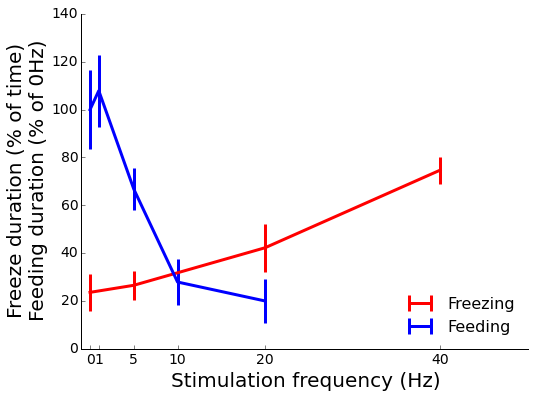

In [46]:
fig, ax = plt.subplots(1, figsize=[8, 6])
freeze_indices = np.array([0,  5, 20, 40])
freq_means = np.array([test_0Hz_mean[0], test_5Hz_mean[0], test_20Hz_mean[0], test_40Hz_mean[0]] )/ 60
freq_stes = np.array([test_0Hz_ste[0],  test_5Hz_ste[0], test_20Hz_ste[0], test_40Hz_ste[0]] ) / 60
plt.errorbar(freeze_indices,  100 *freq_means,  100 *freq_stes, linewidth=lw, label = 'Freezing', color = 'r', capsize = 0)

feed_indices = np.array([0, 1, 5, 10, 20])
max_duration =  mean_mouse_feed_df['duration'][0]
plt.errorbar(feed_indices, 100 *mean_mouse_feed_df['duration'] / max_duration,
              100 *std_mouse_feed_df['duration'] / (max_duration * np.sqrt(NUM_MICE_FEED)),
            label = 'Feeding', linewidth = lw, color = 'b', capsize = 0)
plt.xlim([-1, 50])
plt.ylim([0, 140])

plt.ylabel('Freeze duration (% of time)\nFeeding duration (% of 0Hz)', fontsize = fs)
plt.xlabel('Stimulation frequency (Hz)', fontsize = fs)
plt.xticks([0,1,5,10,20,40])
prettify_axes(plt.gca())
plt.legend(loc='lower right', frameon=False, fontsize = fs-4);
fig.savefig('CalcRL Freezing vs Feeding.png');

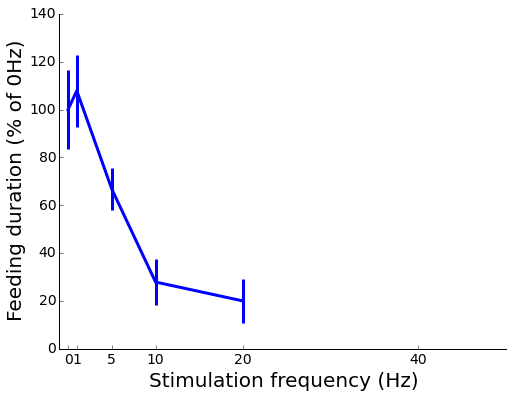

In [53]:
fig, ax = plt.subplots(1, figsize=[8, 6])
feed_indices = np.array([0, 1, 5, 10, 20])
max_duration =  mean_mouse_feed_df['duration'][0]
plt.errorbar(feed_indices, 100 *mean_mouse_feed_df['duration'] / max_duration,
              100 *std_mouse_feed_df['duration'] / (max_duration * np.sqrt(NUM_MICE_FEED)),
            label = 'Feeding', linewidth = lw, color = 'b', capsize = 0)
plt.xlim([-1, 50])
plt.ylim([0, 140])

plt.ylabel('Feeding duration (% of 0Hz)', fontsize = fs)
plt.xlabel('Stimulation frequency (Hz)', fontsize = fs)
plt.xticks([0,1,5,10,20,40])
prettify_axes(plt.gca())
#plt.legend(loc='lower right', frameon=False, fontsize = fs-4);
fig.savefig('CalcRL Freezing vs Feeding.png');

In [18]:
sum_feed_df

start  stop  duration
mouse Hz                       
1     0      87   141        54
      1      71   111        40
      5      20    31        11
      10      0    10        10
      20      0     0         0
2     0     123   175        52
      1     100   154        54
      5      86   122        36
      10      0     2         2
      20      0     1         1
3     0      73    94        21
      1     109   150        41
      5      80   104        24
      10     60    82        22
      20    150   165        15
4     0      74    94        20
      1     115   159        44
      5     115   146        31
      10      0     1         1
      20      0     1         1
5     0      71   127        56
      1       0    60        60
      5     101   122        21
      10      0     2         2
      20      0     0         0
1683  0      49    88        39
      1      44    57        13
      5     137   171        34
      10     44    57        13
      20    160   183        23
2355  0     149   172        23
      1     117   151        34
      5      66    86        20
      10    116   140        24
      20    149   162        13